拿加權指數資料去訓練AE

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# 讀取 CSV 檔案
file_path = "../1.資料前處理/merged_stocks_sorted.csv"
df = pd.read_csv(file_path)
#print(df.head())
# 假設我們要使用數值型的列來做 Autoencoder
#df = df.select_dtypes(include=[np.number]).dropna()

print(df.head())

           日期        成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差  \
0  2010-10-21  20,697,571  2,347,730,094  114.0  114.5  112.5  113.0  -1.00   
1  2010-10-21  40,237,461  2,458,712,121   61.3   61.4   60.8   61.0   0.00   
2  2010-10-21   9,435,865  3,675,093,620  394.0  395.0  386.0  387.0  -5.50   
3  2010-10-22  16,111,879  1,833,691,206  114.5  114.5  113.0  114.0  +1.00   
4  2010-10-22  42,971,490  2,646,457,386   61.7   61.8   61.4   61.8  +0.80   

    成交筆數   SMA_5  ...   SMA_200       EMA_5      EMA_20        RSI       MACD  \
0  9,188  113.60  ...  129.9400  113.598253  115.156901  42.888466  -1.067839   
1  7,376   61.02  ...   60.9100   61.022536   61.126968  49.448148   0.078879   
2  6,346  385.20  ...  496.8100  389.029298  412.053709  32.870088 -18.545872   
3  6,509  113.20  ...  129.7525  113.732169  115.046720  45.751457  -1.032347   
4  9,208   61.00  ...   60.8945   61.281691   61.191067  55.601780   0.124750   

   MACD_signal  MACD_hist  Support_Lev

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 讀取 CSV 檔案
file_path = "../1.資料前處理/merged_stocks_sorted.csv"
df = pd.read_csv(file_path)

# 確保日期是正確的格式並排序
df['日期'] = pd.to_datetime(df['日期'])
df = df.sort_values(by=['日期','股票代碼'])

# 定義需要計算變化的數值型欄位
numeric_cols = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 
                'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 
                'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level']

# 數據前處理
df[numeric_cols] = df[numeric_cols].replace("X0.00", "0")

# 移除 `,` 並轉換為 float
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)


# 創建合併後的 DataFrame，首先複製原始數據
merged_df = df.copy()

# 對漲跌價差進行 MinMax 縮放 (針對每支股票分別處理)
scaler = MinMaxScaler()
for stock_id in merged_df['股票代碼'].unique():
    mask = merged_df['股票代碼'] == stock_id
    # 將漲跌價差重塑為二維陣列（sklearn要求的格式）
    price_diff = merged_df.loc[mask, '漲跌價差'].values.reshape(-1, 1)
    # 進行 MinMax 縮放
    scaled_diff = scaler.fit_transform(price_diff)
    # 將縮放後的值存回 DataFrame
    merged_df.loc[mask, '漲跌價差_pct'] = scaled_diff.flatten()

# 計算其他欄位的百分比變化
for col in [c for c in numeric_cols if c != '漲跌價差']:
    merged_df[f'{col}_pct'] = df.groupby('股票代碼')[col].pct_change() * 100



# 移除含有 NaN 的行
merged_df = merged_df.dropna()

# 查看結果
print("合併後資料的前5筆：")
print(merged_df.head())

# 檢查資料形狀
print("\n資料形狀：", merged_df.shape)

# 檢查是否有任何無限值
inf_count = np.sum(np.isinf(merged_df.select_dtypes(include=[np.number])))
print("\n無限值數量：", inf_count)

# 儲存結果
merged_df.to_csv('stock_data_with_changes.csv', index=False)

# 顯示各欄位數據類型
print("\n各欄位數據類型：")
print(merged_df.dtypes)

合併後資料的前5筆：
          日期        成交股數          成交金額    開盤價    最高價    最低價    收盤價  漲跌價差  \
3 2010-10-22  16111879.0  1.833691e+09  114.5  114.5  113.0  114.0   1.0   
4 2010-10-22  42971490.0  2.646457e+09   61.7   61.8   61.4   61.8   0.8   
5 2010-10-22   7146883.0  2.771465e+09  392.5  392.5  382.5  387.0   0.0   
6 2010-10-25  46473212.0  5.436269e+09  114.0  118.5  114.0  118.5   4.5   
7 2010-10-25  38700363.0  2.398665e+09   62.0   62.2   61.8   62.0   0.2   

      成交筆數  SMA_5  ...  SMA_50_pct  SMA_200_pct  EMA_5_pct  EMA_20_pct  \
3   6509.0  113.2  ...   -0.271370    -0.144297   0.117885   -0.095679   
4   9208.0   61.0  ...    0.052880    -0.025447   0.424687    0.104861   
5   4775.0  384.6  ...   -0.325667    -0.181156  -0.173877   -0.579067   
6  22716.0  114.3  ...   -0.204082    -0.131019   1.397386    0.285870   
7  10753.0   61.3  ...    0.062762    -0.020527   0.390714    0.125903   

        RSI_pct   MACD_pct  MACD_signal_pct  MACD_hist_pct  Support_Level_pct  \
3  6.6

/home/r11011101/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)



各欄位數據類型：
日期                      datetime64[ns]
成交股數                           float64
成交金額                           float64
開盤價                            float64
最高價                            float64
最低價                            float64
收盤價                            float64
漲跌價差                           float64
成交筆數                           float64
SMA_5                          float64
SMA_20                         float64
SMA_60                         float64
SMA_50                         float64
SMA_200                        float64
EMA_5                          float64
EMA_20                         float64
RSI                            float64
MACD                           float64
MACD_signal                    float64
MACD_hist                      float64
Support_Level                  float64
Resistance_Level               float64
股票代碼                             int64
漲跌價差_pct                       float64
成交股數_pct                       float64
成交金額_pct       

將10天的資料串起來

In [42]:
def create_sequences(df, seq_length=10):
    sequences = []
    start_dates = []
    stock_ids = []
    close_prices = []  # 新增收盤價列表
    
    # 只選取需要的欄位 (保留股票代碼和收盤價)
    features = [col for col in df.columns if col.endswith('_pct')]
    df = df[['日期', '股票代碼', '收盤價'] + features]
    
    # 輸出除錯資訊
    print(f"特徵數量: {len(features)}")
    print(f"特徵名稱: {features}")
    
    # 對每個股票分別處理
    for stock_id in df['股票代碼'].unique():
        stock_data = df[df['股票代碼'] == stock_id].sort_values('日期')
        print(f"\n處理股票 {stock_id}")
        print(f"該股票資料筆數: {len(stock_data)}")
        
        # 創建滑動窗口
        for i in range(len(stock_data) - seq_length + 1):
            # 取得當前窗口的數據
            sequence = stock_data.iloc[i:i+seq_length]
            
            # 檢查是否有足夠的數據點
            if len(sequence) == seq_length:
                # 保留特徵數據和股票代碼
                seq_features = sequence[features].values
                sequences.append(seq_features)
                # 記錄序列的起始日期、股票代碼和收盤價
                dates = pd.to_datetime(sequence['日期'])
                start_dates.append(dates.iloc[0])
                stock_ids.append(stock_id)
                close_prices.append(sequence['收盤價'].iloc[0])  # 添加起始日的收盤價
                
                if len(sequences) == 1:  # 輸出第一個成功的序列資訊
                    print(f"成功創建第一個序列，形狀: {seq_features.shape}")
                    print(f"序列日期範圍: {dates.iloc[0]} 到 {dates.iloc[-1]}")
                    print(f"起始日收盤價: {close_prices[0]}")
        
        print(f"該股票產生的序列數: {sum(1 for x in stock_ids if x == stock_id)}")
    
    # 檢查是否有序列被創建
    if not sequences:
        print("警告：沒有找到符合條件的序列")
        return pd.DataFrame()
    
    # 轉換為 numpy array
    sequences = np.array(sequences)
    
    # 創建包含起始日期、股票代碼和收盤價的 DataFrame
    sequences_df = pd.DataFrame({
        'start_date': start_dates,
        'stock_id': stock_ids,
        'close_price': close_prices,  # 添加收盤價欄位
        'sequence': list(sequences)
    })
    
    return sequences_df

# 創建序列數據
sequences_df = create_sequences(merged_df)

# 顯示結果
if not sequences_df.empty:
    print("\n成功創建序列:")
    print(f"序列數據總數: {len(sequences_df)}")
    print("\n前幾筆資料:")
    print(sequences_df[['start_date', 'stock_id', 'close_price']].head())
    print("\n第一個序列的形狀:", sequences_df['sequence'].iloc[0].shape)

特徵數量: 21
特徵名稱: ['漲跌價差_pct', '成交股數_pct', '成交金額_pct', '開盤價_pct', '最高價_pct', '最低價_pct', '收盤價_pct', '成交筆數_pct', 'SMA_5_pct', 'SMA_20_pct', 'SMA_60_pct', 'SMA_50_pct', 'SMA_200_pct', 'EMA_5_pct', 'EMA_20_pct', 'RSI_pct', 'MACD_pct', 'MACD_signal_pct', 'MACD_hist_pct', 'Support_Level_pct', 'Resistance_Level_pct']

處理股票 2317
該股票資料筆數: 3474
成功創建第一個序列，形狀: (10, 21)
序列日期範圍: 2010-10-22 00:00:00 到 2010-11-04 00:00:00
起始日收盤價: 114.0
該股票產生的序列數: 3465

處理股票 2330
該股票資料筆數: 3481
該股票產生的序列數: 3472

處理股票 2454
該股票資料筆數: 3480
該股票產生的序列數: 3471

成功創建序列:
序列數據總數: 10408

前幾筆資料:
  start_date  stock_id  close_price
0 2010-10-22      2317        114.0
1 2010-10-25      2317        118.5
2 2010-10-26      2317        118.0
3 2010-10-27      2317        116.0
4 2010-10-28      2317        116.5

第一個序列的形狀: (10, 21)


切分成10天一組

In [49]:
print(sequences_df.head())
print(sequences_df.tail())
print(sequences_df['sequence'].iloc[0].shape)
print(sequences_df['sequence'].iloc[0])
print(sequences_df.shape)
sequences_df.to_csv('sequences_df.csv', index=False)

  start_date  stock_id  close_price  \
0 2010-10-22      2317        114.0   
1 2010-10-25      2317        118.5   
2 2010-10-26      2317        118.0   
3 2010-10-27      2317        116.0   
4 2010-10-28      2317        116.5   

                                            sequence  
0  [[0.5909090909090909, 0.04873415439923777, 0.0...  
1  [[0.696969696969697, 0.19278865627767772, 0.19...  
2  [[0.5454545454545455, 0.021474672741136496, 0....  
3  [[0.5, 0.05779368409078516, 0.0567681723549817...  
4  [[0.5757575757575758, 0.10654249029475646, 0.1...  
      start_date  stock_id  close_price  \
10403 2024-12-12      2454       1380.0   
10404 2024-12-13      2454       1410.0   
10405 2024-12-16      2454       1385.0   
10406 2024-12-17      2454       1425.0   
10407 2024-12-18      2454       1420.0   

                                                sequence  
10403  [[0.6323529411764706, 0.07118278171142703, 0.0...  
10404  [[0.6323529411764706, 0.05001050901963491, 0.0...  

In [47]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_sequences(sequences_df):
    # 取得所有序列
    all_sequences = np.stack(sequences_df['sequence'].values)
    
    # 重塑數據以便進行標準化 (samples * timesteps, features)
    original_shape = all_sequences.shape
    reshaped_sequences = all_sequences.reshape(-1, original_shape[2])
    
    # 對除了漲跌價差以外的特徵進行標準化
    scaler = MinMaxScaler()
    # 跳過第一個特徵(漲跌價差)，只標準化其他特徵
    reshaped_sequences[:, 1:] = scaler.fit_transform(reshaped_sequences[:, 1:])
    
    # 重塑回原始形狀
    processed_sequences = reshaped_sequences.reshape(original_shape)
    
    # 更新序列資料
    sequences_df['sequence'] = list(processed_sequences)
    
    return sequences_df, scaler

# 處理數據
processed_sequences_df, scaler = preprocess_sequences(sequences_df)

# 檢查處理後的結果
print("處理後的第一個序列:")
print(processed_sequences_df['sequence'].iloc[0])
print(processed_sequences_df.head())

處理後的第一個序列:
[[0.59090909 0.04873415 0.04846365 0.48783055 0.51470588 0.53420678
  0.58480991 0.05029436 0.52115568 0.46192966 0.37485154 0.36544179
  0.28963732 0.58924499 0.48273116 0.33696923 0.90005012 0.16481912
  0.97545864 0.55209007 0.35238433]
 [0.6969697  0.19278866 0.19648508 0.45783658 0.65148985 0.54882626
  0.70030149 0.29222621 0.64673903 0.51302485 0.41578828 0.39246209
  0.30453597 0.71036048 0.57010749 0.43246693 0.89997297 0.16466325
  0.97540813 0.61315813 0.35617729]
 [0.54545455 0.02147467 0.02148467 0.62309878 0.53122673 0.60679235
  0.53552343 0.02272758 0.65415135 0.50279168 0.38396042 0.37860816
  0.30650775 0.6513734  0.55425214 0.28510669 0.89996092 0.16457252
  0.97548983 0.60092762 0.35667928]
 [0.5        0.05779368 0.05676817 0.44400415 0.51470588 0.49109138
  0.48751625 0.05977158 0.58741088 0.48234854 0.3551289  0.36808974
  0.3041526  0.57226787 0.51170523 0.24646278 0.90001816 0.16456293
  0.97546517 0.57649434 0.35607969]
 [0.57575758 0.10654249 0.105

In [48]:
processed_sequences_df = processed_sequences_df.drop(columns=['start_date','stock_id','close_price'])

# 查看結果
print(processed_sequences_df.head())
print(processed_sequences_df.columns)
print(processed_sequences_df.info())



                                            sequence
0  [[0.5909090909090909, 0.04873415439923777, 0.0...
1  [[0.696969696969697, 0.19278865627767772, 0.19...
2  [[0.5454545454545455, 0.021474672741136496, 0....
3  [[0.5, 0.05779368409078516, 0.0567681723549817...
4  [[0.5757575757575758, 0.10654249029475646, 0.1...
Index(['sequence'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10408 entries, 0 to 10407
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  10408 non-null  object
dtypes: object(1)
memory usage: 81.4+ KB
None


In [30]:
print(processed_sequences_df['sequence'].iloc[0].shape)

(10, 21)


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch

# 讀取數據
print(df.head())
print(df.dtypes)

# 列出所有需要轉換為 float 的欄位
float_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5',
       'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI',
       'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level']

df[float_columns] = df[float_columns].replace("X0.00", "0")

# 移除 `,` 並轉換為 float
for col in float_columns:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# 確保所有數據都是數值型
print(df.dtypes)
print(df.head())

# 進行標準化處理 (MinMaxScaler)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values)

print("標準化後的數據:")
print(data_scaled[:5])

# 轉換為 PyTorch Tensor
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

# 查看處理後的數據形狀
print("數據張量形狀:", data_tensor.shape)


         成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差   成交筆數  \
0  20,697,571  2,347,730,094  114.0  114.5  112.5  113.0  -1.00  9,188   
1  40,237,461  2,458,712,121   61.3   61.4   60.8   61.0   0.00  7,376   
2   9,435,865  3,675,093,620  394.0  395.0  386.0  387.0  -5.50  6,346   
3  16,111,879  1,833,691,206  114.5  114.5  113.0  114.0  +1.00  6,509   
4  42,971,490  2,646,457,386   61.7   61.8   61.4   61.8  +0.80  9,208   

    SMA_5   SMA_20  ...   SMA_50   SMA_200       EMA_5      EMA_20        RSI  \
0  113.60  115.825  ...  117.920  129.9400  113.598253  115.156901  42.888466   
1   61.02   61.280  ...   60.514   60.9100   61.022536   61.126968  49.448148   
2  385.20  415.800  ...  442.170  496.8100  389.029298  412.053709  32.870088   
3  113.20  115.650  ...  117.600  129.7525  113.732169  115.046720  45.751457   
4   61.00   61.365  ...   60.546   60.8945   61.281691   61.191067  55.601780   

        MACD  MACD_signal  MACD_hist  Support_Level  Resistance_Leve

In [5]:
print(torch.isnan(data_tensor).sum())  # NaN 個數
print(torch.isinf(data_tensor).sum())  # 無窮大個數

tensor(0)
tensor(0)


In [6]:
nan_rows = torch.any(torch.isnan(data_tensor), dim=1)
print("含 NaN 的行索引:", torch.nonzero(nan_rows))
print("含 NaN 的數據:", data_tensor[nan_rows])


含 NaN 的行索引: tensor([], size=(0, 1), dtype=torch.int64)
含 NaN 的數據: tensor([], size=(0, 21))


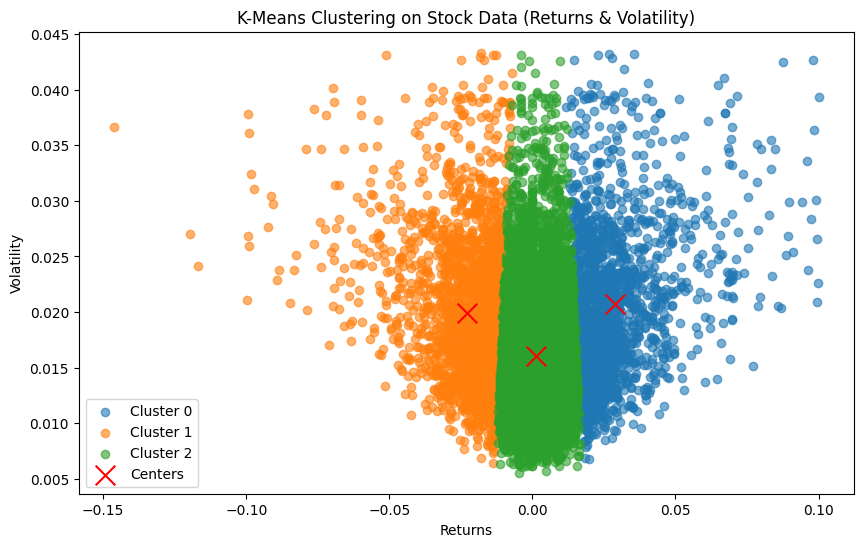

    returns  volatility  cluster
0 -0.008772    0.017411        2
1  0.000000    0.011037        2
2 -0.014013    0.019865        1
3  0.008850    0.017333        2
4  0.013115    0.011250        2


In [25]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 設定要分的群數（可以調整）
num_clusters = 3  

# 執行 K-Means 分群
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df)  # 取得每個數據點的群集標籤

# 可視化結果
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    subset = df[df["cluster"] == cluster]
    plt.scatter(subset["returns"], subset["volatility"], label=f"Cluster {cluster}", alpha=0.6)

# 繪製 K-Means 分群中心點
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, label="Centers")

plt.xlabel("Returns")
plt.ylabel("Volatility")
plt.title("K-Means Clustering on Stock Data (Returns & Volatility)")
plt.legend()
plt.show()

# 顯示部分數據
print(df.head())


/tmp/ipykernel_79333/1638578904.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


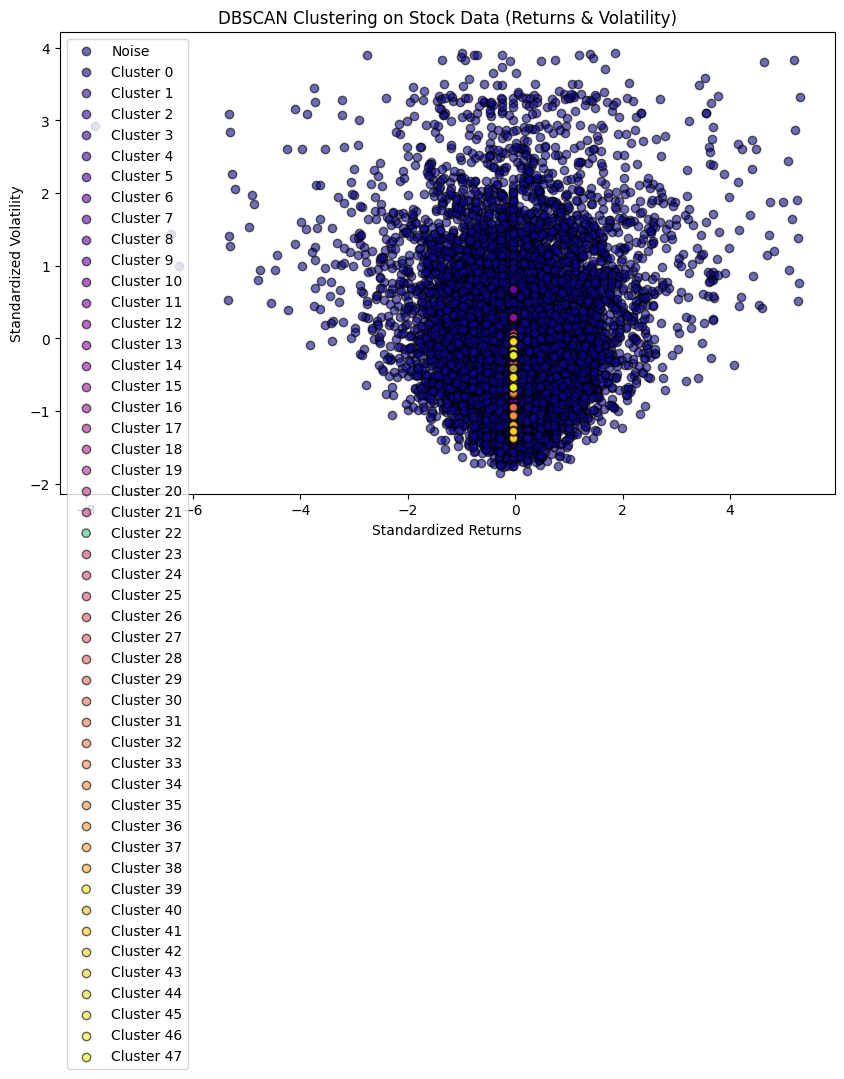

    returns  volatility  cluster
0 -0.008772    0.017411       -1
1  0.000000    0.011037        6
2 -0.014013    0.019865       -1
3  0.008850    0.017333       -1
4  0.013115    0.011250       -1
5  0.000000    0.019864       -1
6  0.039474    0.018585       -1
7  0.003236    0.011220       -1
8  0.020672    0.019401       -1
9 -0.004219    0.014533       -1


In [41]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 標準化數據
scaler = StandardScaler()
df_filtered = df[["returns", "volatility"]].dropna()  # 移除 NaN 值
scaled_data = scaler.fit_transform(df_filtered)  # 標準化數據

# 執行 DBSCAN
dbscan = DBSCAN(eps=0.005, min_samples=5)  # 減小 eps
clusters = dbscan.fit_predict(scaled_data)  # 計算分群

# 將結果加回原始 DataFrame (確保索引對齊)
df.loc[df_filtered.index, "cluster"] = clusters

# 取得唯一群集標籤
unique_clusters = np.unique(clusters)

# 建立顏色對應表
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))  # 生成顏色

plt.figure(figsize=(10, 6))

# 繪製 DBSCAN 群集
for cluster, color in zip(unique_clusters, colors):
    mask = clusters == cluster  # 找到屬於該群的點
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 是雜訊
    plt.scatter(
        scaled_data[mask, 0], scaled_data[mask, 1], 
        c=color, label=label, alpha=0.6, edgecolors='k'
    )

# 加上圖例
plt.legend()
plt.xlabel("Standardized Returns")
plt.ylabel("Standardized Volatility")
plt.title("DBSCAN Clustering on Stock Data (Returns & Volatility)")
plt.show()

# 顯示部分數據
print(df.head(10))


使用load model 讀.pth

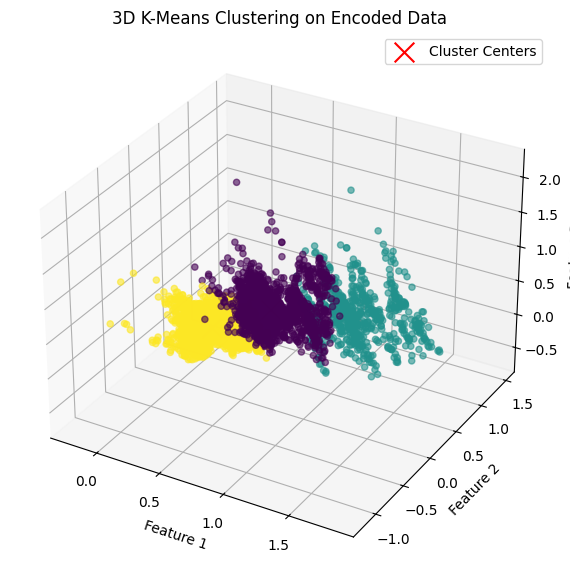

   Feature1  Feature2  Feature3  Cluster
0  0.292578 -0.115719  0.246620        2
1  0.236450 -0.239347  0.170941        2
2  0.528171  0.303397  0.305406        0
3  0.309025 -0.134771  0.225585        2
4  0.258883 -0.293196  0.152621        2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10438 entries, 0 to 10437
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  10438 non-null  float32
 1   Feature2  10438 non-null  float32
 2   Feature3  10438 non-null  float32
 3   Cluster   10438 non-null  int32  
dtypes: float32(3), int32(1)
memory usage: 163.2 KB


In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# 定義 Autoencoder (需與訓練時相同)
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # 壓縮到 3 維
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # 重建原始輸入
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

# 載入數據 (確保 data_tensor 已準備好)
input_dim = data_tensor.shape[1]

# 初始化模型並載入權重
model = AutoEncoder(input_dim)
model.load_state_dict(torch.load("autoencoder_model.pth"))
model.eval()  # 設定為推論模式

# 移動到 CPU 或 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data_tensor = data_tensor.to(device)

# 取得壓縮後的 3D 特徵
with torch.no_grad():
    encoded_data = model.encoder(data_tensor).cpu().numpy()

# K-Means 分群
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(encoded_data)
centers = kmeans.cluster_centers_

# 可視化 3D 分群結果
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], 
    c=clusters, cmap='viridis', alpha=0.6
)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], 
           c='red', marker='x', s=200, label="Cluster Centers")

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("3D K-Means Clustering on Encoded Data")
plt.legend()
plt.show()

# 顯示每個點的分群結果
cluster_df = pd.DataFrame(encoded_data, columns=["Feature1", "Feature2", "Feature3"])
cluster_df["Cluster"] = clusters
print(cluster_df.head())  # 顯示前 5 筆數據

# 儲存結果 (如果需要)
cluster_df.to_csv("clustered_encoded_data.csv", index=False)

cluster_df.info()

/tmp/ipykernel_163814/3880124415.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', num_clusters)  # 使用與 scatter 相同的 colormap


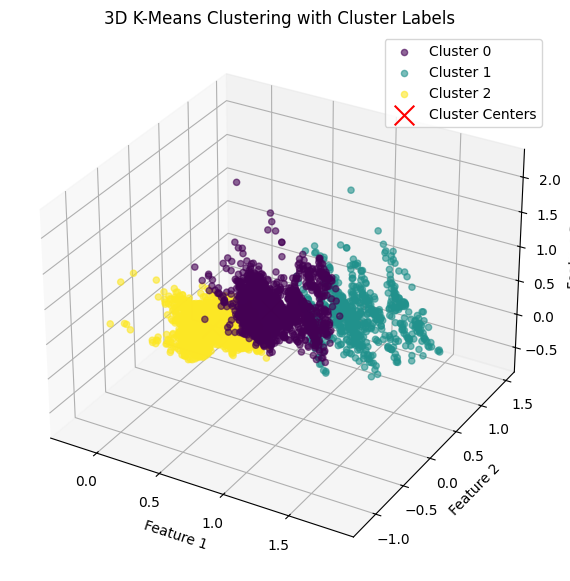

In [11]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 取得唯一的群集標籤
unique_clusters = np.unique(clusters)

# 生成對應的顏色
cmap = cm.get_cmap('viridis', num_clusters)  # 使用與 scatter 相同的 colormap
colors = [cmap(i / num_clusters) for i in range(num_clusters)]  # 產生顏色列表

# 可視化
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 繪製分群點
for cluster_id, color in zip(unique_clusters, colors):
    cluster_points = encoded_data[clusters == cluster_id]  # 取得該群資料點
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
               color=color, label=f"Cluster {cluster_id}", alpha=0.6)

# 繪製群中心
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], 
           c='red', marker='x', s=200, label="Cluster Centers")

# 設定標籤
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("3D K-Means Clustering with Cluster Labels")
ax.legend()
plt.show()

訓練

Epoch [10/100], Average Loss: 0.0026
Epoch [20/100], Average Loss: 0.0024
Epoch [30/100], Average Loss: 0.0024
Epoch [40/100], Average Loss: 0.0024
Epoch [50/100], Average Loss: 0.0023
Epoch [60/100], Average Loss: 0.0023
Epoch [70/100], Average Loss: 0.0023
Epoch [80/100], Average Loss: 0.0023
Epoch [90/100], Average Loss: 0.0023
Epoch [100/100], Average Loss: 0.0023
模型已儲存至 cnn_autoencoder_model.pth


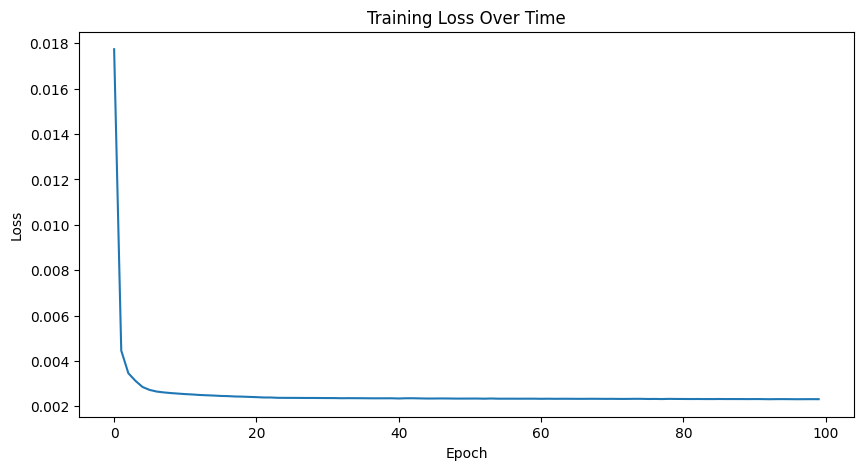

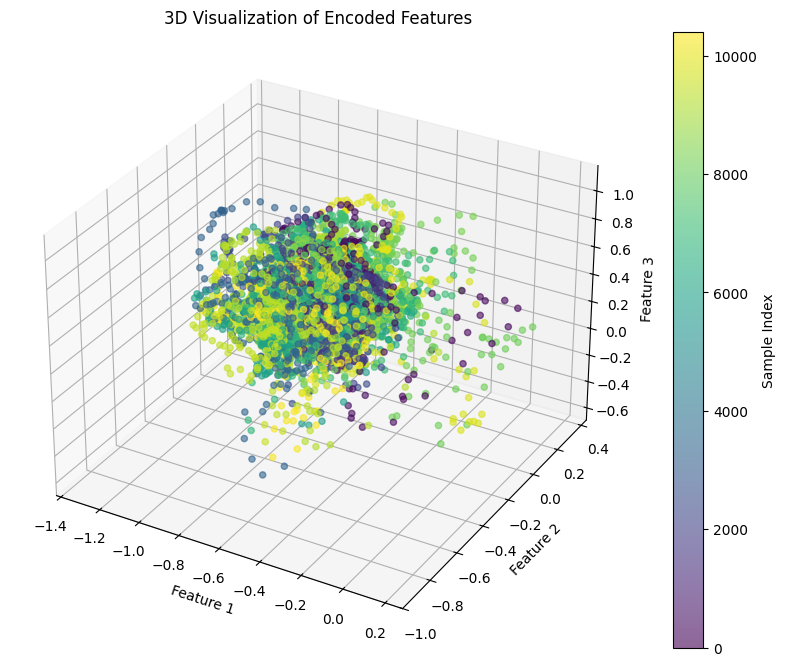

特徵資料已儲存至 encoded_features.csv


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class CNNAutoEncoder(nn.Module):
    def __init__(self, seq_length=10, n_features=21):
        super(CNNAutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # 第一層 1D CNN
            # in_channels=21 (特徵數), out_channels=32, kernel_size=3
            nn.Conv1d(in_channels=n_features, 
                     out_channels=32, 
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            
            # 第二層 1D CNN
            nn.Conv1d(in_channels=32,
                     out_channels=16,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            
            # Flatten層
            nn.Flatten(),
            
            # 全連接層壓縮到3維
            nn.Linear(16 * seq_length, 3)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # 從3維展開
            nn.Linear(3, 16 * seq_length),
            nn.ReLU(),
            
            # 重塑回CNN輸出的形狀
            nn.Unflatten(1, (16, seq_length)),
            
            # 反卷積層
            nn.ConvTranspose1d(16, 32,
                             kernel_size=3,
                             stride=1,
                             padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose1d(32, n_features,
                             kernel_size=3,
                             stride=1,
                             padding=1)
        )
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, n_features)
        # CNN需要的輸入形狀: (batch_size, channels, seq_length)
        x = x.transpose(1, 2)
        
        # 編碼
        z = self.encoder(x)
        
        # 解碼
        # 解碼器輸出形狀: (batch_size, n_features, seq_length)
        x_reconstructed = self.decoder(z)
        
        # 轉回原始形狀 (batch_size, seq_length, n_features)
        x_reconstructed = x_reconstructed.transpose(1, 2)
        
        return x_reconstructed, z

# 資料預處理和模型訓練
def prepare_data(processed_sequences_df):
    # 將序列堆疊成一個大的張量
    sequences = np.stack(processed_sequences_df['sequence'].values)
    # 轉換為PyTorch張量
    data_tensor = torch.FloatTensor(sequences)
    return data_tensor

# 創建資料載入器
def create_dataloader(data_tensor, batch_size=32):
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

def train_model(dataloader, seq_length=10, n_features=21):
    model = CNNAutoEncoder(seq_length, n_features)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    num_epochs = 100
    losses = []  # 記錄損失值
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            x_reconstructed, _ = model(x)
            loss = criterion(x_reconstructed, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
    
    # 儲存模型
    torch.save(model.state_dict(), "cnn_autoencoder_model.pth")
    print("模型已儲存至 cnn_autoencoder_model.pth")
    
    # 繪製損失曲線
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return model

# 使用模型進行特徵提取和視覺化
def visualize_features(model, data_tensor, device):
    model.eval()
    with torch.no_grad():
        # 獲取編碼後的特徵
        encoded_features = []
        for batch in DataLoader(data_tensor, batch_size=32):
            _, z = model(batch.to(device))
            encoded_features.append(z.cpu().numpy())
        
        encoded_features = np.concatenate(encoded_features, axis=0)
        
        # 創建 3D 視覺化
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(encoded_features[:, 0],
                           encoded_features[:, 1],
                           encoded_features[:, 2],
                           c=range(len(encoded_features)),  # 顏色根據時間變化
                           cmap='viridis',
                           alpha=0.6)
        
        plt.colorbar(scatter, label='Sample Index')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Feature 3')
        ax.set_title('3D Visualization of Encoded Features')
        plt.show()
        
        # 儲存特徵資料
        encoded_df = pd.DataFrame(encoded_features, 
                                columns=['Feature1', 'Feature2', 'Feature3'])
        encoded_df.to_csv('encoded_features.csv', index=False)
        print("特徵資料已儲存至 encoded_features.csv")
        

# 訓練模型
data_tensor = prepare_data(processed_sequences_df)
dataloader = create_dataloader(data_tensor)
model = train_model(dataloader)

# 視覺化特徵
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_features(model, data_tensor, device)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# 定義 Autoencoder (需與訓練時相同)
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # 壓縮到 3 維
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # 重建原始輸入
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

# 載入數據 (確保 data_tensor 已準備好)
data_tensor = torch.load("your_data_tensor.pth")  # 請替換為你的數據檔案
input_dim = data_tensor.shape[1]

# 初始化模型並載入權重
model = AutoEncoder(input_dim)
model.load_state_dict(torch.load("autoencoder_model.pth"))
model.eval()  # 設定為推論模式

# 移動到 CPU 或 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data_tensor = data_tensor.to(device)

# 取得壓縮後的 3D 特徵
with torch.no_grad():
    encoded_data = model.encoder(data_tensor).cpu().numpy()

# K-Means 分群
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(encoded_data)
centers = kmeans.cluster_centers_

# 可視化 3D 分群結果
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], 
    c=clusters, cmap='viridis', alpha=0.6
)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], 
           c='red', marker='x', s=200, label="Cluster Centers")

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("3D K-Means Clustering on Encoded Data")
plt.legend()
plt.show()

# 顯示每個點的分群結果
cluster_df = pd.DataFrame(encoded_data, columns=["Feature1", "Feature2", "Feature3"])
cluster_df["Cluster"] = clusters
print(cluster_df.head())  # 顯示前 5 筆數據

# 儲存結果 (如果需要)
cluster_df.to_csv("clustered_encoded_data.csv", index=False)


原始數據前5筆：
   Feature1  Feature2  Feature3
0 -0.675784  0.014135  0.259927
1 -0.673951  0.011014  0.275752
2 -0.668412 -0.000567  0.266177
3 -0.665436 -0.008124  0.256095
4 -0.671571 -0.009925  0.259675


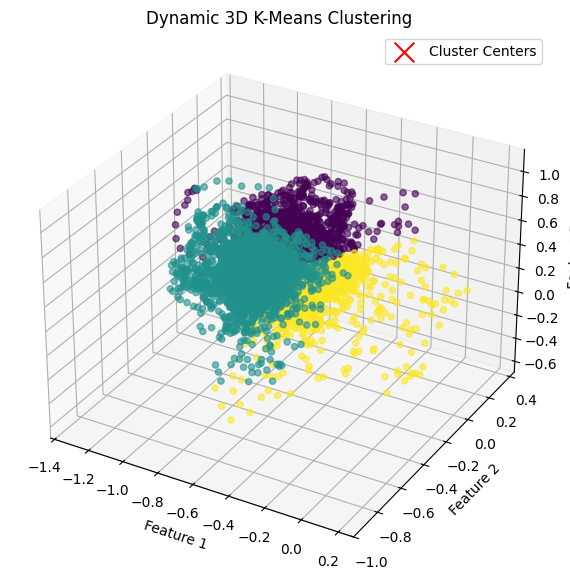


聚類結果統計：
群集 0: 3747 個樣本
群集 1: 4178 個樣本
群集 2: 2483 個樣本

聚類結果已保存至 clustered_encoded_data.csv


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from sklearn.cluster import KMeans

# 讀取特徵數據
encoded_data = pd.read_csv('encoded_features.csv')
print("原始數據前5筆：")
print(encoded_data.head())

# 轉換為numpy陣列進行聚類
X = encoded_data.values
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# 建立 3D 圖表
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 繪製分群點
scatter = ax.scatter(
    X[:, 0], X[:, 1], X[:, 2],
    c=clusters, cmap='viridis', alpha=0.6
)

# 繪製 K-Means 群中心
ax.scatter(
    centers[:, 0], centers[:, 1], centers[:, 2],
    c='red', marker='x', s=200, label="Cluster Centers"
)

# 設定軸標籤
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Dynamic 3D K-Means Clustering")

# 添加圖例
plt.legend()

# 旋轉動畫函數
def rotate(angle):
    ax.view_init(elev=20, azim=angle)

# 創建動畫
animation = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=50)

# 顯示動畫
plt.show()

# 分析聚類結果
print("\n聚類結果統計：")
unique, counts = np.unique(clusters, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"群集 {cluster_id}: {count} 個樣本")

# 如果需要保存結果
cluster_df = pd.DataFrame({
    'Feature1': X[:, 0],
    'Feature2': X[:, 1],
    'Feature3': X[:, 2],
    'Cluster': clusters
})
cluster_df.to_csv('clustered_encoded_data.csv', index=False)
print("\n聚類結果已保存至 clustered_encoded_data.csv")

# 如果要保存動畫
animation.save("3D_kmeans_rotation.gif", writer="pillow", fps=20)

In [40]:
import plotly.express as px
import pandas as pd

# 轉換數據為 DataFrame
df = pd.DataFrame(encoded_data, columns=["Feature1", "Feature2", "Feature3"])
df["Cluster"] = clusters  # 加入分群標籤

# 建立 3D 互動圖
fig = px.scatter_3d(df, x="Feature1", y="Feature2", z="Feature3", color=df["Cluster"].astype(str))

# 顯示 3D 互動視覺化
fig.show()


/home/r11011101/anaconda3/envs/myenv/lib/python3.10/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


/home/r11011101/anaconda3/envs/myenv/lib/python3.10/site-packages/matplotlib/animation.py:872: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



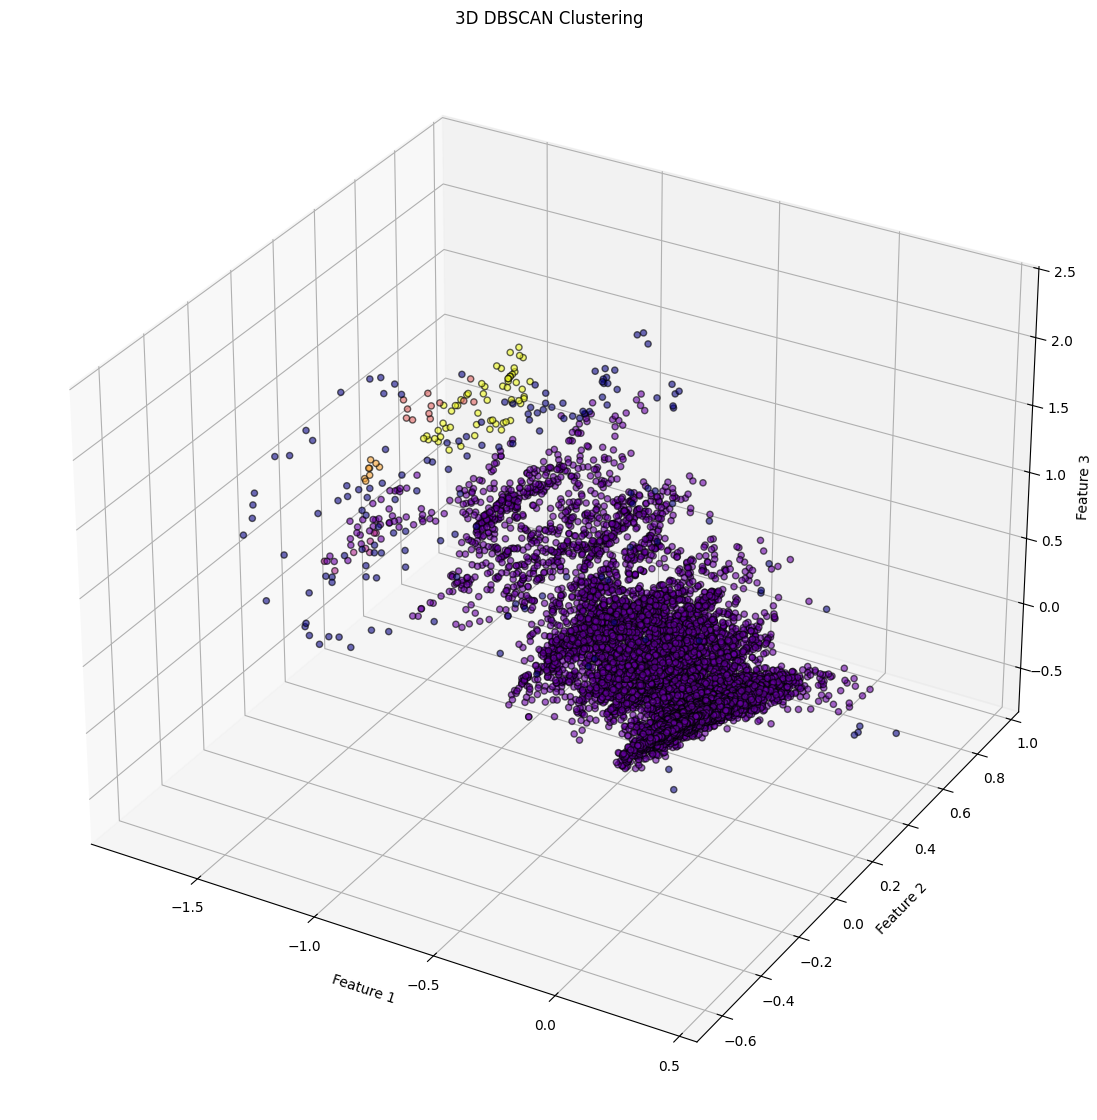

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from sklearn.cluster import DBSCAN

# 執行 DBSCAN 分群
dbscan = DBSCAN(eps=0.15, min_samples=8)
clusters = dbscan.fit_predict(encoded_data)  # 每個點的群集標籤

# 取得唯一的群集標籤
unique_clusters = np.unique(clusters)

# 建立顏色對應表
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))

# 建立 3D 圖表
fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111, projection='3d')

# 繪製每個群集
for cluster, color in zip(unique_clusters, colors):
    mask = clusters == cluster  # 找出屬於該群集的點
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 是雜訊
    ax.scatter(
        encoded_data[mask, 0], encoded_data[mask, 1], encoded_data[mask, 2], 
        c=[color], label=label, alpha=0.6, edgecolors='k'
    )

# 設定軸標籤
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("3D DBSCAN Clustering")

# 旋轉動畫函數
def rotate(angle):
    ax.view_init(elev=20, azim=angle)

# 動畫
animation = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=50)

# 顯示動畫
plt.show()

# 若要存成 GIF / MP4，啟用這行：
# animation.save("3D_DBSCAN_rotation.gif", writer="pillow", fps=20)


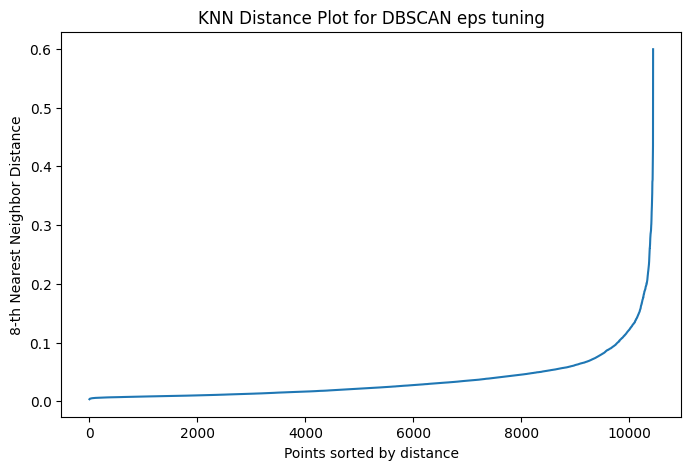

In [119]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# 計算 KNN 距離 (k = min_samples)
k = 8  # 與 DBSCAN 的 min_samples 保持一致
nbrs = NearestNeighbors(n_neighbors=k).fit(encoded_data)
distances, indices = nbrs.kneighbors(encoded_data)

# 取出每個點的 k-距離 (第 k 近的鄰居)
k_distances = np.sort(distances[:, -1])  # 取最後一列 (第 k 近的距離)

# 繪製 KNN 距離圖
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("KNN Distance Plot for DBSCAN eps tuning")
plt.show()


In [120]:
from sklearn.cluster import DBSCAN

for eps in [0.1, 0.12, 0.15]:
    dbscan = DBSCAN(eps=eps, min_samples=8)
    clusters = dbscan.fit_predict(encoded_data)
    print(f"eps={eps}，分群數量: {len(set(clusters)) - (1 if -1 in clusters else 0)}，雜訊數量: {(clusters == -1).sum()}")


eps=0.1，分群數量: 15，雜訊數量: 407
eps=0.12，分群數量: 11，雜訊數量: 281
eps=0.15，分群數量: 5，雜訊數量: 145


In [123]:
import plotly.express as px
import pandas as pd

# 轉換數據為 DataFrame
df = pd.DataFrame(encoded_data, columns=["Feature1", "Feature2", "Feature3"])
df["Cluster"] = clusters  # 加入分群標籤

# 建立 3D 互動圖
fig = px.scatter_3d(df, x="Feature1", y="Feature2", z="Feature3", color=df["Cluster"].astype(str))

# 顯示 3D 互動視覺化
fig.show()


二維數據Kmeans

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 進行 K-Means 分群
num_clusters = 3  # 你可以嘗試不同數值
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(encoded_data)  # 取得每個點的群集標籤

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label="Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means Clustering on 2D Autoencoder Features")
plt.legend()
plt.show()


二維數據DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# 執行 DBSCAN 分群
dbscan = DBSCAN(eps=0.05, min_samples=8)
clusters = dbscan.fit_predict(encoded_data)  # 每個點的群集標籤

# 取得唯一的群集標籤
unique_clusters = np.unique(clusters)

# 建立顏色對應表
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))  # 使用 plasma colormap

plt.figure(figsize=(16, 12))

# 繪製每個群集
for cluster, color in zip(unique_clusters, colors):
    mask = clusters == cluster  # 取得當前群集的索引
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 代表雜訊
    plt.scatter(encoded_data[mask, 0], encoded_data[mask, 1], c=[color], label=label, alpha=0.6, edgecolors='k')

# 加上圖例
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering with Legend")
plt.show()


二維數據尋找dbsacn最佳參數

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

#  建議測試範圍（避免圖太多）
eps_values = np.arange(0.025, 0.11, 0.005)  # 0.005 ~ 0.05, 每次增加 0.005（10 種 eps）
min_samples_values = [3, 5, 10]  # 測試 3 種 min_samples

#  動態調整圖的排列方式
n_rows = len(eps_values)
n_cols = len(min_samples_values)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 6))
fig.suptitle("DBSCAN Clustering with Different Parameters", fontsize=16)

# 迴圈測試不同的 eps 和 min_samples
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        ax = axes[i, j] if n_rows > 1 else axes[j]  # 適應 1 行時的情況
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(encoded_data)  # 執行分群

        unique_clusters = np.unique(clusters)  # 取得不同的群集標籤
        colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))  # 生成顏色

        # 繪製當前參數的分群結果
        for cluster, color in zip(unique_clusters, colors):
            mask = clusters == cluster  # 找到屬於該群的點
            label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 是雜訊
            ax.scatter(encoded_data[mask, 0], encoded_data[mask, 1], c=[color], label=label, alpha=0.6, edgecolors='k')

        ax.set_title(f"eps={eps:.3f}, min_samples={min_samples}")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")

# 調整間距，確保標題不會擠在一起
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


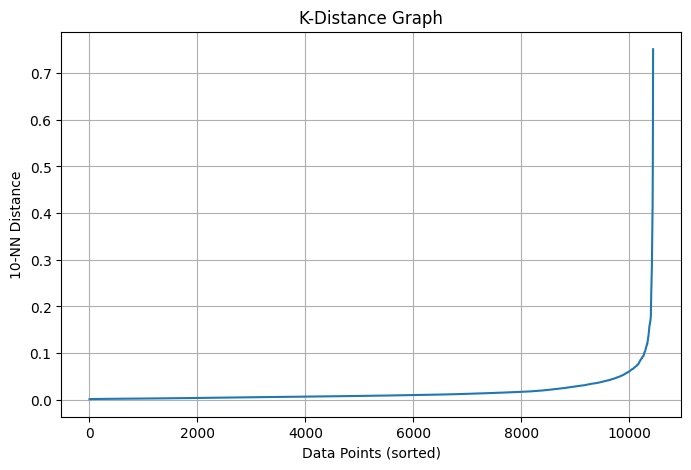

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 計算每個點到其 min_samples 個最近鄰點的距離
min_samples = 10  # 你可以嘗試不同數值
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(encoded_data)
distances, _ = nbrs.kneighbors(encoded_data)

# 取出每個點到 min_samples 鄰居的距離，並排序
k_distances = np.sort(distances[:, -1])

# 繪製 K-Distance Graph
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel(f"{min_samples}-NN Distance")
plt.title("K-Distance Graph")
plt.grid()
plt.show()


In [96]:
for eps in [0.02, 0.03, 0.05, 0.07, 0.1, 0.15]:
    dbscan = DBSCAN(eps=eps, min_samples=10)  
    labels = dbscan.fit_predict(encoded_data)
    
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  
    num_noise = list(labels).count(-1)  
    print(f"eps={eps}: 群集數量={num_clusters}, 噪聲點數量={num_noise}")


eps=0.02: 群集數量=14, 噪聲點數量=1666
eps=0.03: 群集數量=19, 噪聲點數量=986
eps=0.05: 群集數量=11, 噪聲點數量=375
eps=0.07: 群集數量=7, 噪聲點數量=201
eps=0.1: 群集數量=2, 噪聲點數量=86
eps=0.15: 群集數量=1, 噪聲點數量=43


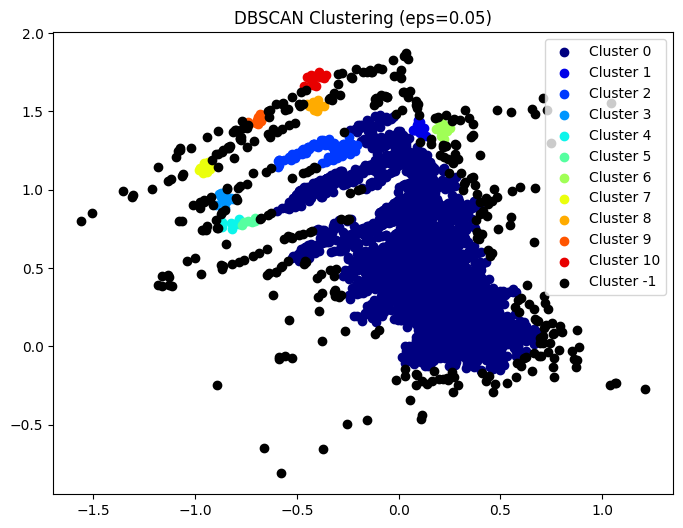

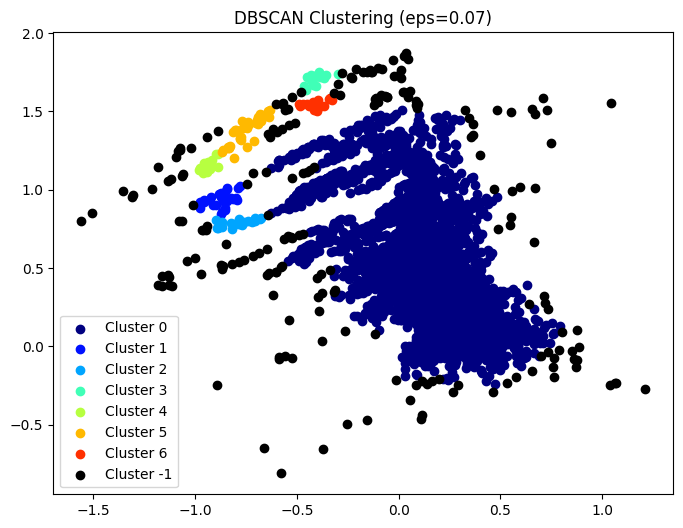

In [99]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dbscan_clusters(data, labels, eps):
    unique_labels = set(labels)
    colors = [plt.cm.jet(each) for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure(figsize=(8, 6))
    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = (0, 0, 0, 1)  # 噪聲點設為黑色
        
        mask = (labels == label)
        plt.scatter(data[mask, 0], data[mask, 1], color=color, label=f'Cluster {label}')

    plt.title(f'DBSCAN Clustering (eps={eps})')
    plt.legend()
    plt.show()

# 嘗試視覺化 eps=0.5 和 eps=0.6
for eps in [0.05, 0.07]:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(encoded_data)
    plot_dbscan_clusters(encoded_data, labels, eps)
